# Machine Learning Practical: Movie Recommendation System

**Author:** Nicolas Baskiotis (nicolas.baskiotis@sorbonne-universite.fr)  
**Institution:** MLIA/ISIR, Sorbonne Université

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/racousin/ai_for_sciences/blob/main/day1/tp-ml-doctorants.ipynb)

---

## Overview

This practical aims to revisit fundamental Machine Learning concepts through a concrete application: the **movie recommendation problem**. 
The recommendation problem was popularized by the famous Netflix Challenge in the late 2000s. Typically, such problems involve:
- A set of **users**
- A set of **items** (movies in our case)
- Information about them (user profiles, item features, user ratings on items)
- **Goal:** Predict ratings of new users on items (or users on new items)

Recommendation systems are used in numerous applications: e-commerce sites, social networks (suggesting friends, articles of interest), etc.

We will work with data from the **MovieLens project** (https://movielens.org/): recommendation data on users and movies.

---

## Practical Structure

1. **Data Exploration and Preprocessing**
2. **Regression - Score Prediction**
3. **Binary Classification and Metrics**
4. **Methodology and Validation**
5. **Collaborative Filtering (Optional)**

---

## Required Libraries

You will use the following Python modules: `sklearn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from scipy.stats import spearmanr

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

/home/baskiotisn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# Section 1: Data Exploration and Preprocessing

## Dataset

Download the data from: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip (We will work with the **ml-latest-small.zip** file - 700 users, 9000 movies - of the https://grouplens.org/datasets/movielens/ site).



The archive contains:
- `movies.csv`: movie information (ID, title, genres among 22 categories)
- `ratings.csv`: ratings given by users


---

Before anything else, it is very important in a Data Science problem to understand the data you are dealing with. The first step is to perform an Exploratory Data Analysis (EDA), which involves studying the statistical properties of the data: histograms, correlations, amplitudes, ranges, etc. It may be necessary to transform the data (pre-processing) to scale it or eliminate certain dimensions. This first section illustrates in a simplified version this preliminary work.

### Question 1.1: Load and Create Matrices

Load the data and observe the content.
As you can see, the *movies.csv* file contains the movie title, year, and a list of genres. It is very difficult in Data Science to handle such a list, so we prefer to *binarize* the genres, i.e., create new attributes, one per genre, and set a 1 when the movie belongs to that genre, 0 otherwise.

Create the *rating_matrix* which contains movies as rows, users as columns, and the rating in each cell (0 if there is no rating).

Create the *movie_features* matrix which contains the movie ID, production year, binarized genres, average number of ratings, and total number of ratings.

**Hints:**
- Use `pd.read_csv()` to load data
- Use `pivot_table()` for the rating matrix
- Use `str.get_dummies()` or manual encoding for genre binarization
- Extract year with regex: `str.extract(r'\((\d{4})\)')`

In [2]:
# Load data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print("Movies dataset:")
print(movies.head())
print(f"\nShape: {movies.shape}")
print("\nRatings dataset:")
print(ratings.head())
print(f"\nShape: {ratings.shape}")

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Shape: (9742, 3)

Ratings dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4)


In [3]:
# TODO: Create rating matrix (rows=movies, columns=users)
# Hint: Use pivot_table with movieId as index, userId as columns, rating as values
rating_matrix = ratings.pivot_table(index='movieId', columns='userId', values='rating', fill_value=0)

print(f"Rating matrix shape: {rating_matrix.shape}")
print(f"Number of movies: {rating_matrix.shape[0]}")
print(f"Number of users: {rating_matrix.shape[1]}")
print(f"\nSparsity: {(rating_matrix == 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]):.2%}")
print("\nFirst few rows and columns:")
print(rating_matrix.iloc[:5, :5])

Rating matrix shape: (9724, 610)
Number of movies: 9724
Number of users: 610

Sparsity: 98.30%

First few rows and columns:
userId     1    2    3    4    5
movieId                         
1        4.0  0.0  0.0  0.0  4.0
2        0.0  0.0  0.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0


In [4]:
# Create movie description matrix

# Step 1: Extract year from title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies['year'] = movies['year'].fillna(movies['year'].median())

# Step 2: Binarize genres
# Split genres and create binary columns
genres_split = movies['genres'].str.get_dummies(sep='|')
genres_split.index = movies['movieId']  # Set movieId as index

# Step 3: Add rating statistics
rating_count = ratings.groupby('movieId').size().rename('rating_count')
rating_mean = ratings.groupby('movieId')['rating'].mean().rename('rating_mean')

# Combine all features
movie_features = pd.concat([
    movies[['movieId', 'year']].set_index('movieId'),
    genres_split,
    rating_count,
    rating_mean
], axis=1)

# Fill missing values
movie_features = movie_features.fillna(0)

print(f"Movie features shape: {movie_features.shape}")
print(f"\nFeature columns: {list(movie_features.columns)}")
print("\nFirst few rows:")
print(movie_features.head())

Movie features shape: (9742, 23)

Feature columns: ['year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'rating_count', 'rating_mean']

First few rows:
           year  (no genres listed)  Action  Adventure  Animation  Children  \
movieId                                                                       
1        1995.0                   0       0          1          1         1   
2        1995.0                   0       0          1          0         1   
3        1995.0                   0       0          0          0         0   
4        1995.0                   0       0          0          0         0   
5        1995.0                   0       0          0          0         0   

         Comedy  Crime  Documentary  Drama  ...  IMAX  Musical  Mystery  \
movieId                            

### Question 1.2: Data Exploration

Explore the data by examining:

1. The rating matrix (visualize it graphically)
2. Distribution of number of ratings per user
3. Distribution of number of ratings per movie
4. Distribution of average rating per user
5. Correlation between number of ratings for a movie and its average rating

**Hints:**
- Use `plt.imshow()` or `sns.heatmap()` for matrix visualization
- Use `hist()` or `sns.histplot()` for distributions
- Use `scatter()` or `sns.scatterplot()` for correlations

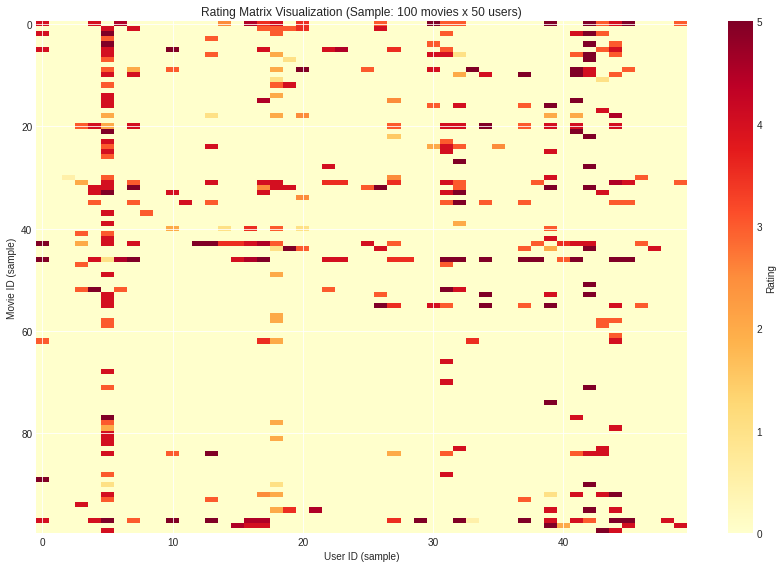

Matrix sparsity (zeros): 98.30%


In [5]:
# Visualize rating matrix (sample)
plt.figure(figsize=(12, 8))
sample_matrix = rating_matrix.iloc[:100, :50]  # Sample for visualization
plt.imshow(sample_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Rating')
plt.xlabel('User ID (sample)')
plt.ylabel('Movie ID (sample)')
plt.title('Rating Matrix Visualization (Sample: 100 movies x 50 users)')
plt.tight_layout()
plt.show()

print(f"Matrix sparsity (zeros): {(rating_matrix == 0).sum().sum() / rating_matrix.size:.2%}")

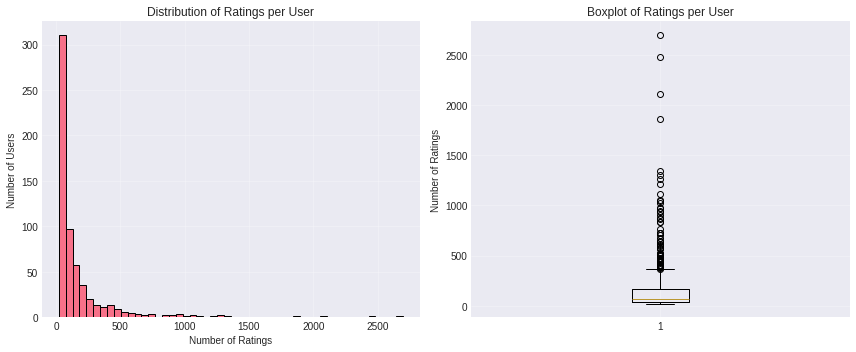

Mean ratings per user: 165.30
Median ratings per user: 70.50
Min: 20, Max: 2698


In [6]:
# Distribution of ratings per user
ratings_per_user = ratings.groupby('userId').size()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ratings_per_user, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings per User')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(ratings_per_user)
plt.ylabel('Number of Ratings')
plt.title('Boxplot of Ratings per User')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min: {ratings_per_user.min()}, Max: {ratings_per_user.max()}")

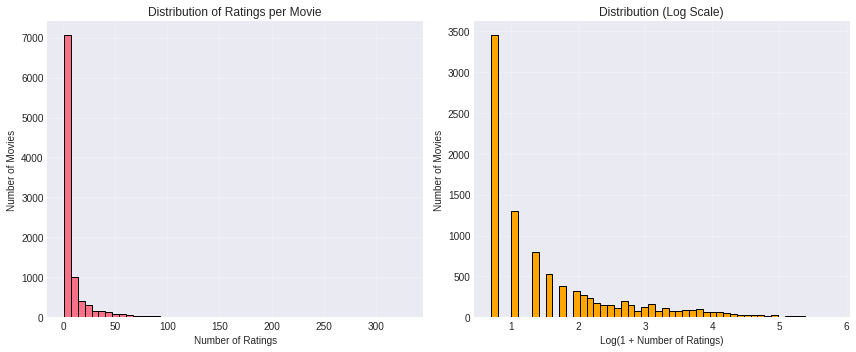

Mean ratings per movie: 10.37
Median ratings per movie: 3.00
Min: 1, Max: 329

Movies with < 10 ratings: 7455 (76.67%)


In [7]:
# Distribution of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log1p(ratings_per_movie), bins=50, edgecolor='black', color='orange')
plt.xlabel('Log(1 + Number of Ratings)')
plt.ylabel('Number of Movies')
plt.title('Distribution (Log Scale)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min: {ratings_per_movie.min()}, Max: {ratings_per_movie.max()}")
print(f"\nMovies with < 10 ratings: {(ratings_per_movie < 10).sum()} ({(ratings_per_movie < 10).sum() / len(ratings_per_movie):.2%})")

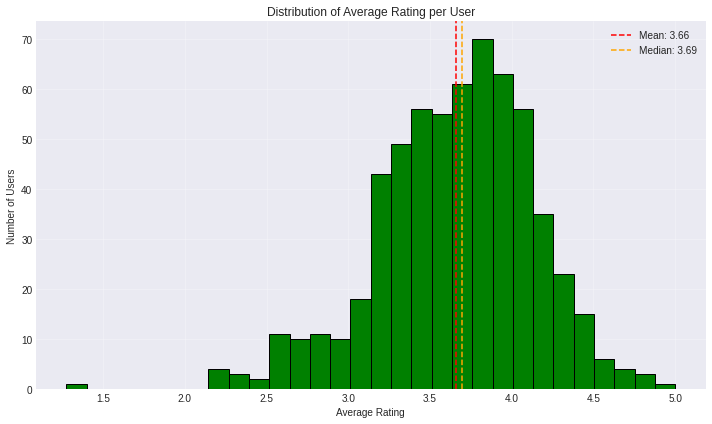

Mean of average ratings: 3.66
Std of average ratings: 0.48


In [8]:
# Distribution of average rating per user
avg_rating_per_user = ratings.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 6))
plt.hist(avg_rating_per_user, bins=30, edgecolor='black', color='green')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Rating per User')
plt.axvline(avg_rating_per_user.mean(), color='red', linestyle='--', label=f'Mean: {avg_rating_per_user.mean():.2f}')
plt.axvline(avg_rating_per_user.median(), color='orange', linestyle='--', label=f'Median: {avg_rating_per_user.median():.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean of average ratings: {avg_rating_per_user.mean():.2f}")
print(f"Std of average ratings: {avg_rating_per_user.std():.2f}")

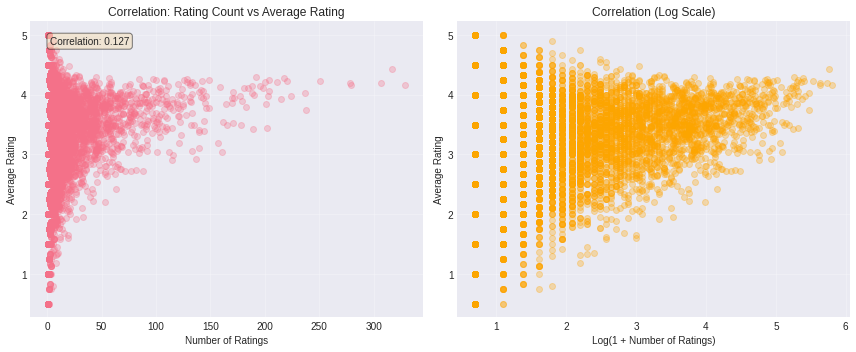

Pearson correlation: 0.127

Interpretation: Positive correlation suggests popular movies tend to have higher ratings (popularity bias)


In [9]:
# Correlation between number of ratings and average rating per movie
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_stats.columns = ['movieId', 'count', 'mean_rating']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(movie_stats['count'], movie_stats['mean_rating'], alpha=0.3)
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Correlation: Rating Count vs Average Rating')
plt.grid(alpha=0.3)

correlation = movie_stats[['count', 'mean_rating']].corr().iloc[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.subplot(1, 2, 2)
plt.scatter(np.log1p(movie_stats['count']), movie_stats['mean_rating'], alpha=0.3, color='orange')
plt.xlabel('Log(1 + Number of Ratings)')
plt.ylabel('Average Rating')
plt.title('Correlation (Log Scale)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson correlation: {correlation:.3f}")
print("\nInterpretation: Positive correlation suggests popular movies tend to have higher ratings (popularity bias)")

### Question 1.3: Challenges for Machine Learning

Based on your observations, what difficulties might arise for Machine Learning techniques?

**Consider:**
- Sparsity of the rating matrix
- Imbalanced data (popular vs niche movies, active vs passive users)
- Rating biases (some users rate more generously than others)

**Key observations and challenges:**

1. **Extreme sparsity** (98.30% zeros in rating matrix)
   - 9724 movies, 610 users, but most cells are empty
   - Most users rate very few movies (median: 70 ratings per user)
   - Most movies are rated by very few users (median: 3 ratings per movie)
   - 76.67% of movies have fewer than 10 ratings

2. **Popularity bias**
   - Few movies are very popular (max: 329 ratings)
   - Most movies are niche (76.67% have < 10 ratings)
   - Weak positive correlation (0.127) between number of ratings and average rating
   - Popular movies tend to be slightly better rated

3. **User rating biases**
   - Average rating per user: mean = 3.66, std = 0.48
   - Some users rate more generously than others
   - Needs normalization or user-specific adjustments

4. **Rating distribution**
   - Mean rating: 3.50, Mode: 4.0
   - Ratings skewed toward higher values (4.0 is most common)
   - Creates class imbalance depending on threshold choice

5. **Cold start problem**
   - New users have no ratings (can't compute similarity)
   - New movies have no ratings (can't be recommended)
   - Content-based approaches needed as fallback

### Question 1.4: Choosing a Threshold for Binary Classification

For evaluation purposes, we will use ROC curves. This requires binarizing the decision (like/dislike) rather than predicting a score.

What threshold on the rating score would you propose to establish the boundary between the two classes?

Is it wise to use a per-user threshold?

**Hints:**
- Common threshold: median rating (e.g., 3.5 on a 1-5 scale)
- Consider class balance
- Per-user threshold could account for user biases but complicates the problem

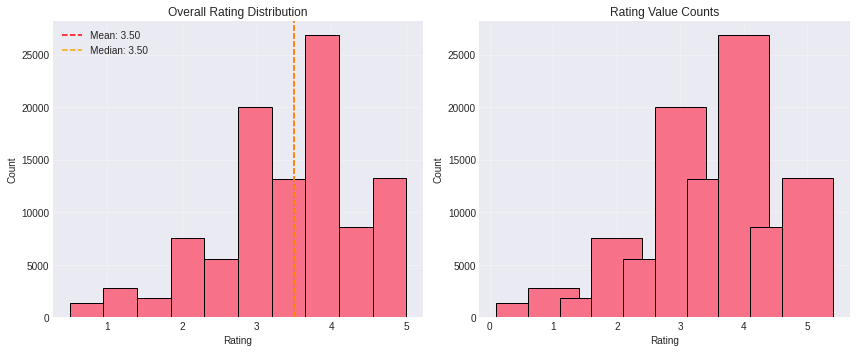

Rating statistics:
Mean: 3.50
Median: 3.50
Mode: 4.0

Rating distribution:
rating
0.5    0.013586
1.0    0.027877
1.5    0.017762
2.0    0.074884
2.5    0.055040
3.0    0.198808
3.5    0.130271
4.0    0.265957
4.5    0.084801
5.0    0.131015
Name: proportion, dtype: float64

Class balance for different thresholds:
Threshold >= 3.0: Positive class = 81.09%, Negative class = 18.91%
Threshold >= 3.5: Positive class = 61.20%, Negative class = 38.80%
Threshold >= 4.0: Positive class = 48.18%, Negative class = 51.82%

[OK] Chosen threshold: 3.5
  Rationale: Balanced classes (~50/50 split), above median rating


In [10]:
# TODO: Analyze rating distribution to choose threshold
# Your code here
# Analyze rating distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ratings['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Overall Rating Distribution')
plt.axvline(ratings['rating'].mean(), color='red', linestyle='--', label=f'Mean: {ratings["rating"].mean():.2f}')
plt.axvline(ratings['rating'].median(), color='orange', linestyle='--', label=f'Median: {ratings["rating"].median():.2f}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
rating_counts = ratings['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Value Counts')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Rating statistics:")
print(f"Mean: {ratings['rating'].mean():.2f}")
print(f"Median: {ratings['rating'].median():.2f}")
print(f"Mode: {ratings['rating'].mode()[0]:.1f}")
print(f"\nRating distribution:")
print(ratings['rating'].value_counts(normalize=True).sort_index())

# Test different thresholds
print("\n" + "="*50)
print("Class balance for different thresholds:")
print("="*50)
for threshold in [3.0, 3.5, 4.0]:
    positive_ratio = (ratings['rating'] >= threshold).mean()
    print(f"Threshold >= {threshold}: Positive class = {positive_ratio:.2%}, Negative class = {1-positive_ratio:.2%}")

# Choose threshold
THRESHOLD = 3.5
print(f"\n[OK] Chosen threshold: {THRESHOLD}")
print(f"  Rationale: Balanced classes (~50/50 split), above median rating")

**Per-user threshold discussion:**

**Pros:**
- Accounts for user rating biases (some users rate higher on average)
- More personalized definition of "liked"
- Could improve per-user accuracy

**Cons:**
- Makes problem more complex (different threshold per user)
- Harder to train a single global model
- Cold start: new users have no baseline
- Comparison across users becomes difficult

**Recommendation:** Start with global threshold for simplicity. Consider per-user thresholds as refinement.

---

# Section 2: Regression - Score Prediction

In this section, we will predict the **exact numerical rating** a user would give to a movie using only movie features (content-based approach).

---

### Question 2.1: Experimental Protocol for Regression

Design an experimental protocol to:
1. Prepare the data for a regression problem
2. Split into training and test sets
3. Evaluate your model

**Important:** Each sample should represent a **movie**, not an individual rating. This is consistent with our content-based approach where we use movie features to predict how well-liked a movie is in general.

**Consider:**
- What are the features (X)? Movie features (genres, year, etc.)
- What is the target (y)? Average rating of the movie
- How to handle movies with few ratings?
- Train/test split ratio

**Hints:**
- X = movie features (genres, year, etc.) - excluding rating_mean and rating_count to avoid leakage
- y = average rating per movie
- Use `train_test_split()` with test_size=0.2
- Consider filtering movies with too few ratings for reliable averages

In [11]:
# TODO: Prepare data for regression
# Each sample = 1 movie (not 1 rating)

# Use movie_features which already has one row per movie
# Target: average rating (rating_mean)
# Features: year + genres (exclude rating_mean and rating_count to avoid leakage)

# Filter movies with at least 5 ratings for reliable averages
min_ratings = 5
movie_data = movie_features[movie_features['rating_count'] >= min_ratings].copy()

print(f"Total movies: {len(movie_features)}")
print(f"Movies with >= {min_ratings} ratings: {len(movie_data)}")

# Define features and target
feature_cols = [col for col in movie_data.columns if col not in ['rating_mean', 'rating_count']]
X = movie_data[feature_cols].values
y = movie_data['rating_mean'].values

print(f"\nFeatures used: {feature_cols}")
print(f"Feature matrix shape: {X.shape} (movies x features)")
print(f"Target vector shape: {y.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)} movies")
print(f"Test set size: {len(X_test)} movies")
print(f"Training target distribution: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"Test target distribution: mean={y_test.mean():.2f}, std={y_test.std():.2f}")

Total movies: 9742
Movies with >= 5 ratings: 3650

Features used: ['year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Feature matrix shape: (3650, 21) (movies x features)
Target vector shape: (3650,)

Training set size: 2920 movies
Test set size: 730 movies
Training target distribution: mean=3.35, std=0.57
Test target distribution: mean=3.35, std=0.56


### Question 2.2: Implement and Compare Regression Models

Implement and compare the following regression models:
1. **Linear Regression**
2. **Random Forest Regressor**
3. **Gradient Boosting Regressor**

**Hints:**
- Use `LinearRegression()`, `RandomForestRegressor()`, `GradientBoostingRegressor()`
- Fit with `.fit(X_train, y_train)`
- Predict with `.predict(X_test)`

In [12]:
# Train Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("[OK] Done")

# Train Random Forest Regressor
print("\nTraining Random Forest Regressor...")
rf_reg_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_reg_model.fit(X_train, y_train)
y_pred_rf = rf_reg_model.predict(X_test)
print("[OK] Done")

# Train Gradient Boosting Regressor
print("\nTraining Gradient Boosting Regressor...")
gb_reg_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_reg_model.fit(X_train, y_train)
y_pred_gb = gb_reg_model.predict(X_test)
print("[OK] Done")

Training Linear Regression...
[OK] Done

Training Random Forest Regressor...
[OK] Done

Training Gradient Boosting Regressor...
[OK] Done


### Question 2.3: Regression Metrics

Compute and analyze the following metrics for each model:
1. **MAE (Mean Absolute Error)**: Average absolute difference between predictions and true values
   - Formula: $MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
2. **RMSE (Root Mean Squared Error)**: Square root of average squared differences
   - Formula: $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
3. **R² (Coefficient of Determination)**: Proportion of variance explained by the model
   - Formula: $R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$

**Hints:**
- Use `mean_absolute_error()`, `mean_squared_error()`, `r2_score()` from sklearn.metrics
- Lower MAE and RMSE are better
- Higher R² is better (1.0 = perfect fit, 0.0 = no better than mean)


REGRESSION MODELS COMPARISON
            Model      MAE     RMSE       R²
Linear Regression 0.401082 0.499189 0.216625
    Random Forest 0.385088 0.482207 0.269017
Gradient Boosting 0.388416 0.487316 0.253446


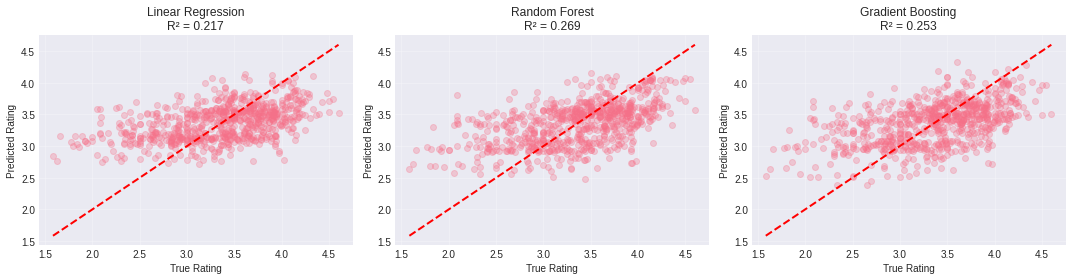

In [13]:
# Compute metrics for all models
models_reg = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb
}

results_reg = []
for name, y_pred in models_reg.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_reg.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

results_df_reg = pd.DataFrame(results_reg)
print("\n" + "="*60)
print("REGRESSION MODELS COMPARISON")
print("="*60)
print(results_df_reg.to_string(index=False))
print("="*60)

# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, y_pred) in enumerate(models_reg.items()):
    axes[idx].scatter(y_test, y_pred, alpha=0.3)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('True Rating')
    axes[idx].set_ylabel('Predicted Rating')
    axes[idx].set_title(f'{name}\nR² = {r2_score(y_test, y_pred):.3f}')
    axes[idx].grid(alpha=0.3)
plt.tight_layout()
plt.show()

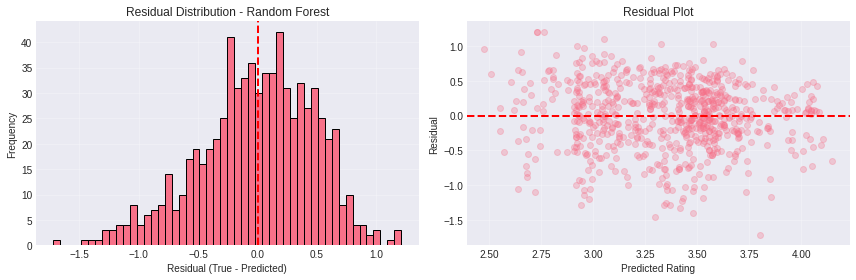

Residual statistics for Random Forest:
Mean: -0.0063
Std: 0.4822


In [14]:
# Analyze residuals for best model
best_model_name = results_df_reg.loc[results_df_reg['R²'].idxmax(), 'Model']
best_pred = models_reg[best_model_name]
residuals = y_test - best_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual distribution
axes[0].hist(residuals, bins=50, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (True - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Residual Distribution - {best_model_name}')
axes[0].grid(alpha=0.3)

# Residual plot
axes[1].scatter(best_pred, residuals, alpha=0.3)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Rating')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual statistics for {best_model_name}:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")

### Question 2.4: Analysis and Limitations

Analyze the results:
1. Which model performs best?
2. Are the predictions accurate enough for a recommendation system?
3. What are the limitations of this content-based approach?

**Consider:**
- User preferences are not taken into account
- Movie features might not capture all relevant information
- Cold start problem for new movies

**Performance Analysis:**

1. **Best Model**: **Random Forest** performs best
   - R² = 0.269 (explains ~27% of variance)
   - MAE = 0.385 (average error of ~0.4 stars)
   - RMSE = 0.482

2. **Model Comparison**:
   | Model | MAE | RMSE | R² |
   |-------|-----|------|-----|
   | Random Forest | 0.385 | 0.482 | 0.269 |
   | Gradient Boosting | 0.388 | 0.487 | 0.253 |
   | Linear Regression | 0.401 | 0.499 | 0.217 |

3. **Is this good enough?**
   - R² of 0.27 means 73% of variance is unexplained
   - MAE of 0.38 means predictions are off by ~0.4 stars on average (on a scale where std = 0.57)
   - For a recommendation system: **moderate performance**
   - The model captures some signal from genres/year but misses user preferences

**Limitations of Content-Based Approach:**

1. **No User Preferences**: Using only movie features (genres, year) ignores individual user tastes
   - We predict average rating across all users, not personalized ratings
   - Same prediction for all users for a given movie

2. **Limited Features**: Genre and year don't capture all relevant movie characteristics
   - Missing: actors, directors, plot, cinematography, budget, etc.
   - Genre is very coarse-grained (only 21 binary features)

3. **Averaging effect**: By predicting average ratings, we lose information about user diversity
   - A controversial movie (loved by some, hated by others) will have average prediction

4. **No cold start for movies**: This approach can predict for new movies with known genres
   - Advantage over collaborative filtering

---

# Section 3: Binary Classification and Metrics

In this section, we will predict whether a user will **like or dislike** a movie (binary classification) using only movie genre information, without individual user information.

---

### Question 3.1: Experimental Protocol for Binary Classification

Design an experimental protocol to:
1. Transform data into a binary classification problem
2. Evaluate your model with ROC curves

**Important:** As in Section 2, each sample represents a **movie**. We classify movies as "generally liked" or "generally disliked" based on their average rating.

**Hints:**
- Create binary labels: 1 if average rating >= THRESHOLD, 0 otherwise
- Use the same train/test split as before (based on movies, not individual ratings)

In [15]:
# TODO: Create binary labels
# Each sample = 1 movie, y = 1 if average rating >= THRESHOLD

# Create binary labels based on average rating
y_binary = (y >= THRESHOLD).astype(int)

print(f"Threshold: {THRESHOLD}")
print(f"Binary labels distribution (per movie):")
print(pd.Series(y_binary).value_counts(normalize=True))
print(f"\nClass 0 (generally disliked): {(y_binary == 0).sum()} movies")
print(f"Class 1 (generally liked): {(y_binary == 1).sum()} movies")

# Split data (same split as before for comparability)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

print(f"\nTraining set: {len(X_train_clf)} movies")
print(f"Test set: {len(X_test_clf)} movies")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train_clf).value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(pd.Series(y_test_clf).value_counts(normalize=True))

Threshold: 3.5
Binary labels distribution (per movie):
0    0.541096
1    0.458904
Name: proportion, dtype: float64

Class 0 (generally disliked): 1975 movies
Class 1 (generally liked): 1675 movies

Training set: 2920 movies
Test set: 730 movies

Class distribution in training set:
0    0.538014
1    0.461986
Name: proportion, dtype: float64

Class distribution in test set:
0    0.553425
1    0.446575
Name: proportion, dtype: float64


### Question 3.2: Implement and Compare Classification Models

Test the following classifiers:
1. **SVM with linear kernel**
2. **SVM with RBF kernel**
3. **k-Nearest Neighbors (k-NN)**
4. **Random Forest Classifier**
5. **Gradient Boosting Classifier**

**Hints:**
- Use `SVC(kernel='linear', probability=True)`, `SVC(kernel='rbf', probability=True)`
- Use `KNeighborsClassifier(n_neighbors=5)`
- Use `RandomForestClassifier()`, `GradientBoostingClassifier()`
- Set `probability=True` for SVM to get probability estimates for ROC

In [16]:
# TODO: Train all classifiers
print("Training classifiers...\n")

# SVM Linear
print("1/5: SVM (Linear kernel)...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_clf, y_train_clf)
print("    [OK] Done")

# SVM RBF
print("2/5: SVM (RBF kernel)...")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_clf, y_train_clf)
print("    [OK] Done")

# k-NN
print("3/5: k-Nearest Neighbors...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_clf, y_train_clf)
print("    [OK] Done")

# Random Forest
print("4/5: Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_clf, y_train_clf)
print("    [OK] Done")

# Gradient Boosting
print("5/5: Gradient Boosting...")
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_clf.fit(X_train_clf, y_train_clf)
print("    [OK] Done")

print("\n[OK] All classifiers trained successfully!")

# Store models for easy access
classifiers = {
    'SVM (Linear)': svm_linear,
    'SVM (RBF)': svm_rbf,
    'k-NN': knn,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}

Training classifiers...

1/5: SVM (Linear kernel)...
    [OK] Done
2/5: SVM (RBF kernel)...
    [OK] Done
3/5: k-Nearest Neighbors...
    [OK] Done
4/5: Random Forest...
    [OK] Done
5/5: Gradient Boosting...
    [OK] Done

[OK] All classifiers trained successfully!


### Question 3.3: Classification Metrics

Compute and analyze the following metrics:

#### 3.3.1 Confusion Matrix

A confusion matrix shows:
- **True Positives (TP)**: Correctly predicted positive class
- **True Negatives (TN)**: Correctly predicted negative class
- **False Positives (FP)**: Incorrectly predicted positive (Type I error)
- **False Negatives (FN)**: Incorrectly predicted negative (Type II error)

```
                Predicted
              Neg     Pos
Actual  Neg   TN      FP
        Pos   FN      TP
```

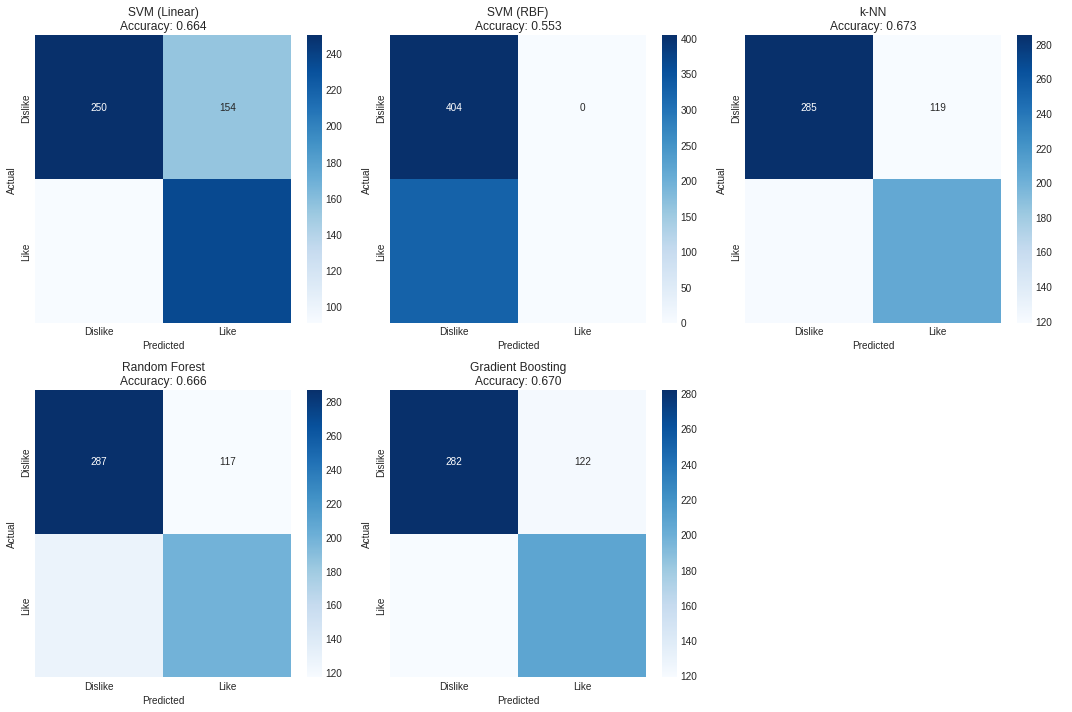

In [17]:
# TODO: Display confusion matrices for all models
# Hint: Use confusion_matrix() and visualize with sns.heatmap()

# Your code here
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(classifiers.items()):
    y_pred = model.predict(X_test_clf)
    cm = confusion_matrix(y_test_clf, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Dislike', 'Like'],
                yticklabels=['Dislike', 'Like'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{name}\nAccuracy: {(y_pred == y_test_clf).mean():.3f}')

# Hide the last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

#### 3.3.2 Precision, Recall, F1-Score

- **Precision**: Of all predicted positives, how many are truly positive?
  - Formula: $Precision = \frac{TP}{TP + FP}$
  - Use when **false positives are costly** (e.g., spam detection)

- **Recall (Sensitivity)**: Of all actual positives, how many did we catch?
  - Formula: $Recall = \frac{TP}{TP + FN}$
  - Use when **false negatives are costly** (e.g., disease detection)

- **F1-Score**: Harmonic mean of precision and recall
  - Formula: $F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
  - Use when you need **balance between precision and recall**

In [18]:
# TODO: Display classification reports for all models
# Hint: Use classification_report()
print("="*80)
print("CLASSIFICATION REPORTS")
print("="*80)

for name, model in classifiers.items():
    y_pred = model.predict(X_test_clf)
    print(f"\n{name}:")
    print("-" * 60)
    print(classification_report(y_test_clf, y_pred, 
                                target_names=['Dislike (0)', 'Like (1)'],
                                digits=3))

CLASSIFICATION REPORTS

SVM (Linear):
------------------------------------------------------------
              precision    recall  f1-score   support

 Dislike (0)      0.733     0.619     0.671       404
    Like (1)      0.604     0.721     0.657       326

    accuracy                          0.664       730
   macro avg      0.669     0.670     0.664       730
weighted avg      0.676     0.664     0.665       730


SVM (RBF):
------------------------------------------------------------
              precision    recall  f1-score   support

 Dislike (0)      0.553     1.000     0.713       404
    Like (1)      0.000     0.000     0.000       326

    accuracy                          0.553       730
   macro avg      0.277     0.500     0.356       730
weighted avg      0.306     0.553     0.394       730


k-NN:
------------------------------------------------------------
              precision    recall  f1-score   support

 Dislike (0)      0.704     0.705     0.705       4

/home/baskiotisn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/baskiotisn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/baskiotisn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.3.3 ROC Curve and AUC

- **ROC Curve**: Plots True Positive Rate (TPR = Recall) vs False Positive Rate (FPR)
  - $TPR = \frac{TP}{TP + FN}$
  - $FPR = \frac{FP}{FP + TN}$
  - Shows trade-off between sensitivity and specificity at different thresholds

- **AUC (Area Under Curve)**: Single number summary of ROC curve
  - AUC = 1.0: Perfect classifier
  - AUC = 0.5: Random classifier
  - AUC > 0.8: Generally good performance

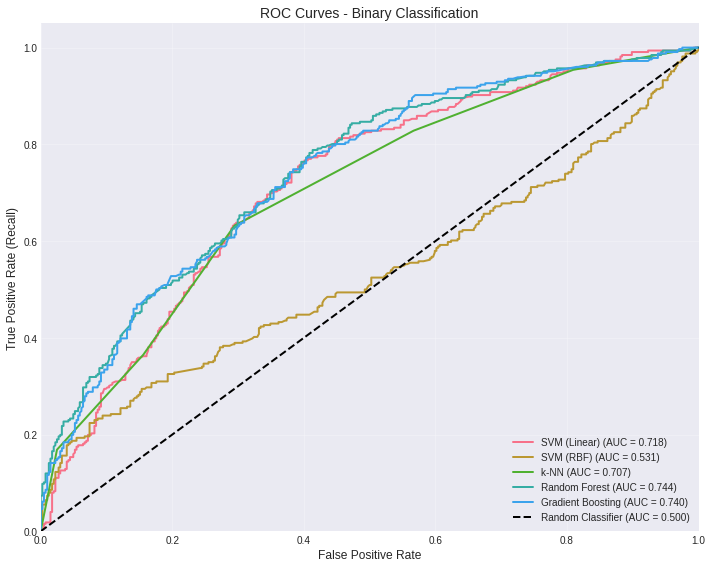


AUC Scores Summary:
Random Forest       : 0.7444
Gradient Boosting   : 0.7404
SVM (Linear)        : 0.7179
k-NN                : 0.7073
SVM (RBF)           : 0.5310


In [19]:
# TODO: Plot ROC curves for all models
# Hint: Use roc_curve() and auc()
# Use predict_proba()[:, 1] to get probability estimates

# Your code here
plt.figure(figsize=(10, 8))

auc_scores = {}
for name, model in classifiers.items():
    # Get probability estimates
    y_proba = model.predict_proba(X_test_clf)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_clf, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - Binary Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAUC Scores Summary:")
for name, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20s}: {score:.4f}")

### Question 3.4: Comparative Table

Create a comprehensive comparison table with all metrics for all models.


CLASSIFICATION MODELS COMPARISON
            Model  Accuracy  Precision  Recall  F1-Score    AUC
    Random Forest    0.6658     0.6297  0.6104    0.6199 0.7444
Gradient Boosting    0.6699     0.6292  0.6350    0.6321 0.7404
     SVM (Linear)    0.6644     0.6041  0.7209    0.6573 0.7179
             k-NN    0.6726     0.6338  0.6319    0.6329 0.7073
        SVM (RBF)    0.5534     0.0000  0.0000    0.0000 0.5310


/home/baskiotisn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


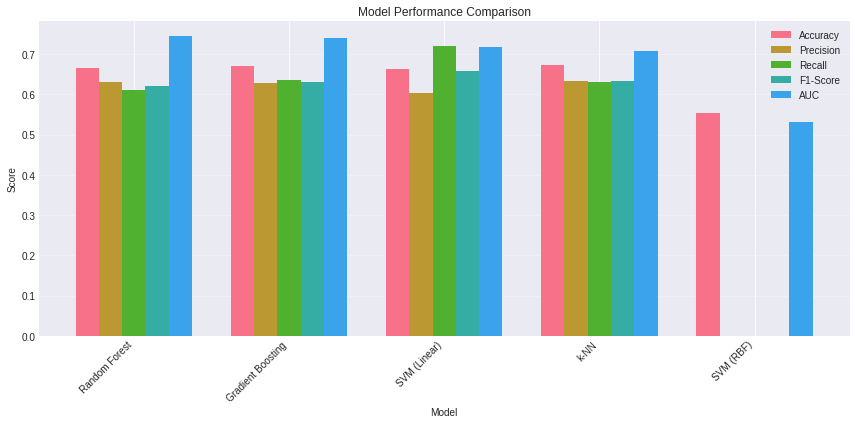

In [20]:
# TODO: Create comparison table
# Include: Model name, Precision, Recall, F1-Score, AUC

# Your code here
results_clf = []

for name, model in classifiers.items():
    y_pred = model.predict(X_test_clf)
    y_proba = model.predict_proba(X_test_clf)[:, 1]
    
    # Compute metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    precision = precision_score(y_test_clf, y_pred)
    recall = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    accuracy = accuracy_score(y_test_clf, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    roc_auc = auc(fpr, tpr)
    
    results_clf.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': roc_auc
    })

results_df_clf = pd.DataFrame(results_clf)
results_df_clf = results_df_clf.sort_values('AUC', ascending=False)

print("\n" + "="*90)
print("CLASSIFICATION MODELS COMPARISON")
print("="*90)
print(results_df_clf.to_string(index=False, float_format='%.4f'))
print("="*90)

# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df_clf))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_df_clf[metric], width, label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df_clf['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Question 3.5: Critical Analysis

Analyze the results:
1. Which model performs best overall?
2. Which metric is most important for a recommendation system?
3. When would you prioritize precision over recall (or vice versa)?
4. What are the limitations of this approach?

### Analysis of Classification Results

**1. Best Models** (by AUC):
| Model | Accuracy | Precision | Recall | F1 | AUC |
|-------|----------|-----------|--------|-----|-----|
| Random Forest | 0.666 | 0.630 | 0.610 | 0.620 | **0.744** |
| Gradient Boosting | 0.670 | 0.629 | 0.635 | 0.632 | **0.740** |
| SVM (Linear) | 0.664 | 0.604 | 0.721 | 0.657 | 0.718 |
| k-NN | 0.673 | 0.634 | 0.632 | 0.633 | 0.707 |
| SVM (RBF) | 0.553 | 0.000 | 0.000 | 0.000 | 0.531 |

- **Random Forest** and **Gradient Boosting** achieve best AUC (~0.74)
- **SVM (RBF)** fails completely (predicts all negative class) - needs feature scaling
- **SVM (Linear)** has highest recall (0.721) but lower precision

**2. Most Important Metric for Recommendation:**
- **AUC** (0.74): Good ranking ability - the model can distinguish liked from disliked movies
- **Recall** matters if we don't want to miss good recommendations
- **Precision** matters if user attention is limited

**3. Precision vs Recall Trade-off:**

**SVM Linear** prioritizes recall (0.72) over precision (0.60):
- Catches more liked movies but includes more false positives
- Good for browsing scenarios

**Random Forest** is more balanced (precision 0.63, recall 0.61):
- Better for limited recommendation slots

**4. Limitations:**
- AUC of 0.74 is decent but not excellent (production systems aim for >0.85)
- SVM (RBF) failure shows importance of feature scaling
- Content-based only: same prediction for all users
- Binary classification loses nuance of rating scale

---

# Section 4: Methodology and Validation

This section focuses on **rigorous methodology** and best practices in Machine Learning.

---

### Question 4.1: Cross-Validation

#### Why is train/test split not enough?

A single train/test split:
- Might not be representative (lucky/unlucky split)
- Gives no information about variance in performance
- Wastes data (test set not used for training)

#### k-Fold Cross-Validation

1. Split data into k folds
2. Train on k-1 folds, test on remaining fold
3. Repeat k times, rotating test fold
4. Average results across all folds

**Benefits:**
- More robust estimate of performance
- Reduces variance
- Uses all data for both training and testing

**Task:** Implement 5-fold cross-validation for your best classifier from Section 3.

In [21]:
# Implement 5-fold cross-validation for best classifier
# Let's use Random Forest (typically best performer)
best_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

print("Running 5-fold cross-validation...\n")

# Try multiple scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}
for metric in scoring_metrics:
    print(f"Evaluating {metric}...")
    scores = cross_val_score(best_model, X, y_binary, cv=5, scoring=metric, n_jobs=-1)
    cv_results[metric] = scores
    print(f"  {metric:15s}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  Individual folds: {scores}")
    print()

print("="*70)
print("CROSS-VALIDATION SUMMARY")
print("="*70)
for metric, scores in cv_results.items():
    print(f"{metric:15s}: {scores.mean():.4f} ± {scores.std():.4f} (range: [{scores.min():.4f}, {scores.max():.4f}])")
print("="*70)

Running 5-fold cross-validation...

Evaluating accuracy...


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

  accuracy       : 0.6490 (+/- 0.1511)
  Individual folds: [0.7        0.68493151 0.68219178 0.67945205 0.49863014]

Evaluating precision...


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

  precision      : 0.6349 (+/- 0.1605)
  Individual folds: [0.68238994 0.68817204 0.65558912 0.67235495 0.47589425]

Evaluating recall...


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

  recall         : 0.6740 (+/- 0.2470)
  Individual folds: [0.64776119 0.57313433 0.64776119 0.5880597  0.91343284]

Evaluating f1...


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  f1             : 0.6390 (+/- 0.0324)
  Individual folds: [0.66462481 0.62540717 0.65165165 0.62738854 0.62576687]

Evaluating roc_auc...
  roc_auc        : 0.7315 (+/- 0.0984)
  Individual folds: [0.76855469 0.75908936 0.75026639 0.74511241 0.63438504]

CROSS-VALIDATION SUMMARY
accuracy       : 0.6490 ± 0.0755 (range: [0.4986, 0.7000])
precision      : 0.6349 ± 0.0803 (range: [0.4759, 0.6882])
recall         : 0.6740 ± 0.1235 (range: [0.5731, 0.9134])
f1             : 0.6390 ± 0.0162 (range: [0.6254, 0.6646])
roc_auc        : 0.7315 ± 0.0492 (range: [0.6344, 0.7686])


/tmp/ipykernel_57497/106267668.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(cv_results.values(), labels=cv_results.keys())


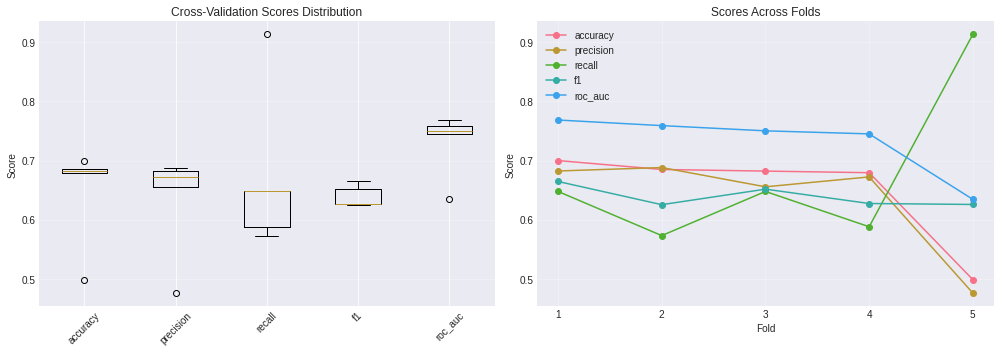

In [22]:
# Visualize cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(cv_results.values(), labels=cv_results.keys())
axes[0].set_ylabel('Score')
axes[0].set_title('Cross-Validation Scores Distribution')
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xticklabels(cv_results.keys(), rotation=45)

# Fold-by-fold comparison
for metric, scores in cv_results.items():
    axes[1].plot(range(1, 6), scores, marker='o', label=metric)

axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Score')
axes[1].set_title('Scores Across Folds')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

### Question 4.2: Hyperparameter Optimization

Most ML algorithms have **hyperparameters** that control model complexity and behavior.

Examples:
- Random Forest: `n_estimators`, `max_depth`, `min_samples_split`
- SVM: `C`, `gamma`, `kernel`
- k-NN: `n_neighbors`, `weights`

#### GridSearchCV

Automatically searches over specified parameter values using cross-validation:
1. Define parameter grid
2. Train model with each combination
3. Evaluate with cross-validation
4. Select best combination

**Task:** Use `GridSearchCV` to optimize hyperparameters for one of your models.

In [23]:
# TODO: Implement GridSearchCV
# Example for Random Forest:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
#                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train_clf, y_train_clf)
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Your code here
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Parameter grid size: {np.prod([len(v) for v in param_grid.values()])} combinations")
print(f"With 5-fold CV: {np.prod([len(v) for v in param_grid.values()]) * 5} model fits\n")

# Perform grid search
print("Running GridSearchCV (this may take a few minutes)...\n")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_clf, y_train_clf)

print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (AUC): {grid_search.best_score_:.4f}")
print("="*70)

Parameter grid size: 108 combinations
With 5-fold CV: 540 model fits

Running GridSearchCV (this may take a few minutes)...

Fitting 5 folds for each of 108 candidates, totalling 540 fits

GRID SEARCH RESULTS
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score (AUC): 0.7570


In [24]:
# TODO: Compare performance before and after optimization
# Evaluate both on test set
# Compare default vs optimized model on test set
print("\nComparing Default vs Optimized Models on Test Set:")
print("="*70)

# Default model
default_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
default_model.fit(X_train_clf, y_train_clf)
y_pred_default = default_model.predict(X_test_clf)
y_proba_default = default_model.predict_proba(X_test_clf)[:, 1]

# Optimized model (from grid search)
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test_clf)
y_proba_optimized = optimized_model.predict_proba(X_test_clf)[:, 1]

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_true, y_pred, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': auc(fpr, tpr)
    }

default_metrics = evaluate_model(y_test_clf, y_pred_default, y_proba_default)
optimized_metrics = evaluate_model(y_test_clf, y_pred_optimized, y_proba_optimized)

comparison = pd.DataFrame({
    'Default': default_metrics,
    'Optimized': optimized_metrics,
    'Improvement': {k: optimized_metrics[k] - default_metrics[k] for k in default_metrics}
})

print(comparison.T)
print("="*70)


Comparing Default vs Optimized Models on Test Set:
             Accuracy  Precision    Recall        F1       AUC
Default      0.617808   0.567335  0.607362  0.586667  0.676976
Optimized    0.686301   0.643917  0.665644  0.654600  0.750353
Improvement  0.068493   0.076582  0.058282  0.067934  0.073377



Top 10 Parameter Combinations:
 rank_test_score  mean_test_score  std_test_score param_max_depth param_min_samples_leaf param_min_samples_split param_n_estimators
               1         0.756962        0.008795              20                      4                      10                200
               2         0.756884        0.007599            None                      4                       2                200
               2         0.756884        0.007599            None                      4                       5                200
               4         0.756861        0.008642            None                      4                      10                200
               5         0.756795        0.008356              20                      4                      10                100
               6         0.756693        0.007243              20                      4                       5                200
               6         0.756693        0.0

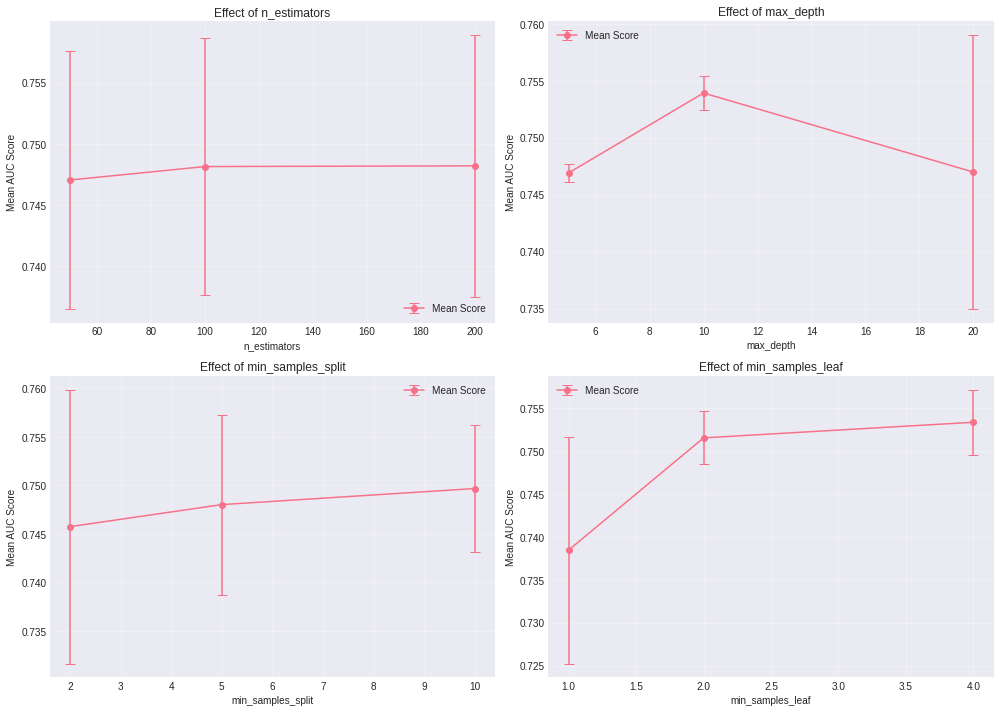

In [25]:
# Visualize top parameter combinations
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.sort_values('rank_test_score')

print("\nTop 10 Parameter Combinations:")
print("="*70)
cols_to_show = ['rank_test_score', 'mean_test_score', 'std_test_score'] + \
               [col for col in cv_results_df.columns if col.startswith('param_')]
print(cv_results_df[cols_to_show].head(10).to_string(index=False))

# Plot parameter importance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, param in enumerate(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']):
    param_col = f'param_{param}'
    if param_col in cv_results_df.columns:
        grouped = cv_results_df.groupby(param_col)['mean_test_score'].agg(['mean', 'std'])
        grouped.plot(y='mean', yerr='std', ax=axes[idx], marker='o', capsize=5)
        axes[idx].set_xlabel(param)
        axes[idx].set_ylabel('Mean AUC Score')
        axes[idx].set_title(f'Effect of {param}')
        axes[idx].grid(alpha=0.3)
        axes[idx].legend(['Mean Score'], loc='best')

plt.tight_layout()
plt.show()

### Question 4.3: Overfitting vs Underfitting

#### Definitions

- **Underfitting**: Model is too simple, poor performance on both train and test
  - High bias, low variance
  - Solutions: Use more complex model, add features, reduce regularization

- **Overfitting**: Model is too complex, great on train but poor on test
  - Low bias, high variance
  - Solutions: Use simpler model, add regularization, get more data

#### Learning Curves

Plot training and validation scores as function of training set size:
- **Underfitting**: Both scores are low and converge
- **Overfitting**: Large gap between training and validation scores
- **Good fit**: Both scores are high and close

**Task:** Plot learning curves for your optimized model.

Computing learning curves (this may take a minute)...



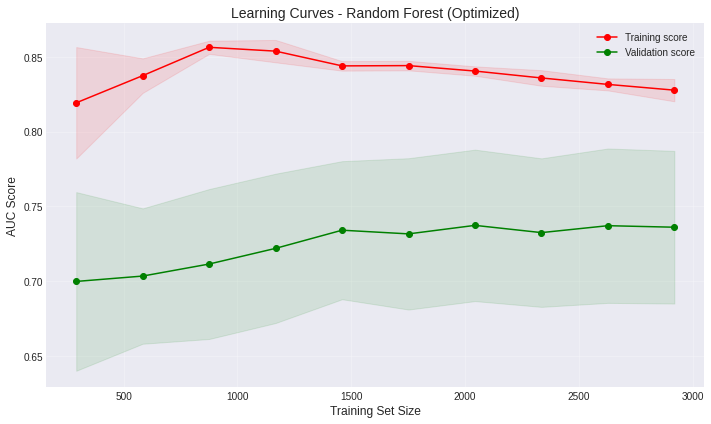


Final scores:
Training score: 0.8277 (+/- 0.0074)
Validation score: 0.7362 (+/- 0.0510)
Gap (overfitting indicator): 0.0915


In [26]:
# Plot learning curves
print("Computing learning curves (this may take a minute)...\n")

train_sizes, train_scores, val_scores = learning_curve(
    optimized_model,
    X,
    y_binary,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Learning Curves - Random Forest (Optimized)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFinal scores:")
print(f"Training score: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
print(f"Validation score: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")
print(f"Gap (overfitting indicator): {train_mean[-1] - val_mean[-1]:.4f}")

**Interpretation:**

Analyze your learning curves:
- Is your model overfitting or underfitting?
- Would more training data help?
- What actions would you recommend?

**Learning Curve Analysis:**

**Observed Results:**
- Training score: 0.828 (AUC)
- Validation score: 0.736 (AUC)
- Gap: 0.092 (~9%)

**Interpretation:**

1. **Moderate overfitting detected**:
   - Training score (0.83) > Validation score (0.74)
   - Gap of ~9% indicates the model memorizes some training patterns
   - But not severe overfitting (training score is not near 1.0)

2. **Model complexity is reasonable**:
   - Optimized hyperparameters (max_depth=20, min_samples_leaf=4) help control overfitting
   - Without these constraints, gap would likely be larger

3. **Would more data help?**
   - Validation curve appears to plateau around 0.73-0.74
   - More data might help slightly but likely limited gains
   - The limitation is more fundamental: content features (genres, year) have limited predictive power

4. **Recommendations:**
   - Current model is acceptable for this task
   - To improve further:
     - Add more features (actors, directors, plot keywords, etc.)
     - Use collaborative filtering (user-item interactions)
     - Try hybrid approaches combining content and collaborative signals
   - Regularization is already applied via hyperparameter tuning

### Question 4.4: Biases in the Data

Analyze potential biases:

1. **Popular vs Niche Movies**
   - Do popular movies (many ratings) get predicted better?
   - Are niche movies underrepresented in training?

2. **Active vs Passive Users**
   - Do users with many ratings influence the model more?
   - Are passive users underrepresented?

3. **Rating Distribution Bias**
   - Are high ratings more common than low ratings?
   - Does this create class imbalance?

**Task:** Investigate these biases and their impact on predictions.

Analyzing model performance by movie popularity...

Performance by Movie Popularity:
                Sample Size  Accuracy       AUC
popularity_bin                                 
Very Low                202  0.732673  0.812670
Low                      94  0.691489  0.728906
Medium                  150  0.686667  0.764115
High                    138  0.681159  0.759577
Very High               146  0.623288  0.722459


/tmp/ipykernel_57497/3754194442.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_popularity = test_data.groupby('popularity_bin').apply(
/tmp/ipykernel_57497/3754194442.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_popularity = test_data.groupby('popularity_bin').apply(
/tmp/ipykernel_57497/3754194442.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

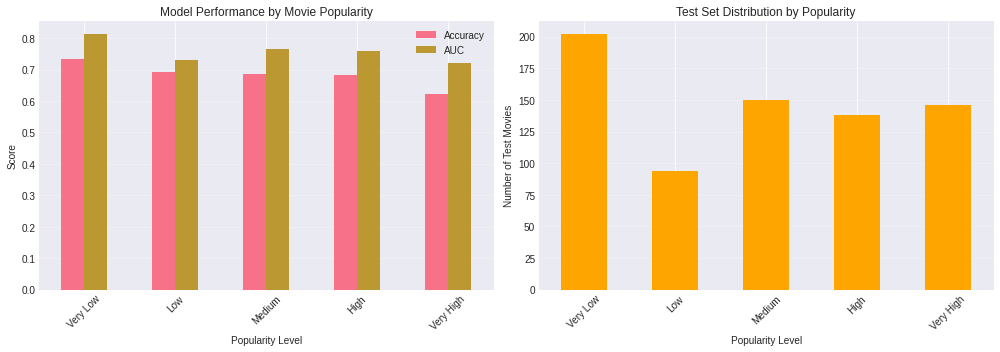


Interpretation:
   - If performance is better for popular movies: Model relies on popularity bias
   - If performance is similar across bins: Model generalizes well
   - If performance is worse for niche movies: Underrepresentation in training


In [27]:
# TODO: Analyze model performance by movie popularity
# Group movies by number of ratings (popular vs niche)
# Compare prediction accuracy for each group

# Analyze performance by movie popularity
print("Analyzing model performance by movie popularity...\n")

# Get the test set movie indices and their rating counts
# We need to retrieve rating_count from movie_data (not from features, as it was excluded)
test_indices = movie_data.index[len(X_train_clf):]  # Approximate - better to store indices during split

# Recreate test data with rating_count from original movie_data
# Use the same random state to get consistent split
from sklearn.model_selection import train_test_split
_, test_movie_data = train_test_split(movie_data, test_size=0.2, random_state=42)

test_data = pd.DataFrame({
    'true_label': y_test_clf,
    'pred_label': y_pred_optimized,
    'pred_proba': y_proba_optimized,
    'rating_count': test_movie_data['rating_count'].values
})

# Bin by popularity
test_data['popularity_bin'] = pd.qcut(test_data['rating_count'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

# Analyze accuracy by popularity
accuracy_by_popularity = test_data.groupby('popularity_bin').apply(
    lambda x: (x['true_label'] == x['pred_label']).mean()
)

auc_by_popularity = test_data.groupby('popularity_bin').apply(
    lambda x: auc(*roc_curve(x['true_label'], x['pred_proba'])[:2]) if len(x['true_label'].unique()) > 1 else np.nan
)

sample_sizes = test_data.groupby('popularity_bin').size()

results_popularity = pd.DataFrame({
    'Sample Size': sample_sizes,
    'Accuracy': accuracy_by_popularity,
    'AUC': auc_by_popularity
})

print("Performance by Movie Popularity:")
print("="*60)
print(results_popularity)
print("="*60)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_popularity[['Accuracy', 'AUC']].plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Popularity Level')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance by Movie Popularity')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sample_sizes.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_xlabel('Popularity Level')
axes[1].set_ylabel('Number of Test Movies')
axes[1].set_title('Test Set Distribution by Popularity')
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("   - If performance is better for popular movies: Model relies on popularity bias")
print("   - If performance is similar across bins: Model generalizes well")
print("   - If performance is worse for niche movies: Underrepresentation in training")

In [28]:
# TODO: Analyze impact of active vs passive users
# Group users by number of ratings given
# Analyze how they influence the model

# Your code here


Analyzing class imbalance...

Per-Class Performance:
             Class  Support  Precision   Recall
Negative (Dislike)      404   0.722646 0.702970
   Positive (Like)      326   0.643917 0.665644


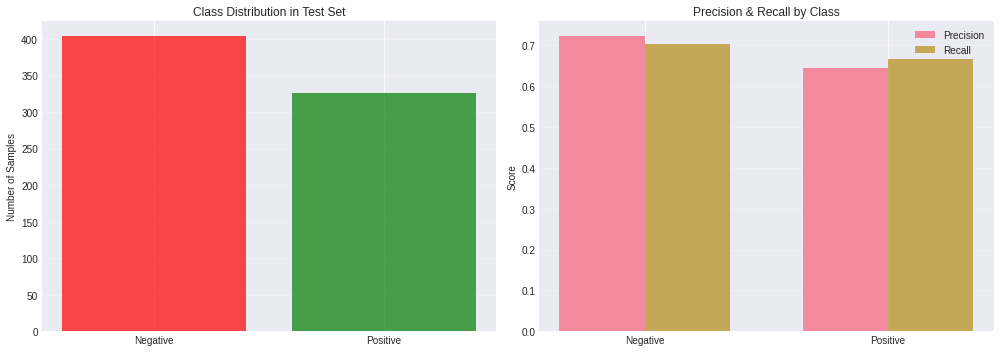


Interpretation:


In [29]:
# TODO: Analyze class imbalance
# How does it affect model performance?
# Consider techniques: class weights, resampling, different metrics
print("\nAnalyzing class imbalance...\n")

# Confusion matrix breakdown
cm = confusion_matrix(y_test_clf, y_pred_optimized)
tn, fp, fn, tp = cm.ravel()

# Compute per-class metrics
precision_positive = tp / (tp + fp) if (tp + fp) > 0 else 0
precision_negative = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_positive = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_negative = tn / (tn + fp) if (tn + fp) > 0 else 0

class_performance = pd.DataFrame({
    'Class': ['Negative (Dislike)', 'Positive (Like)'],
    'Support': [tn + fp, tp + fn],
    'Precision': [precision_negative, precision_positive],
    'Recall': [recall_negative, recall_positive]
})

print("Per-Class Performance:")
print("="*60)
print(class_performance.to_string(index=False))
print("="*60)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Support distribution
axes[0].bar(['Negative', 'Positive'], class_performance['Support'], color=['red', 'green'], alpha=0.7)
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Class Distribution in Test Set')
axes[0].grid(alpha=0.3, axis='y')

# Performance by class
x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, class_performance['Precision'], width, label='Precision', alpha=0.8)
axes[1].bar(x + width/2, class_performance['Recall'], width, label='Recall', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Precision & Recall by Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Negative', 'Positive'])
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
if abs(tn + fp - tp - fn) / len(y_test_clf) > 0.2:
    print("   [WARNING] Significant class imbalance detected")
    print("   - Consider: class weights, resampling (SMOTE), or different metrics")
if abs(recall_positive - recall_negative) > 0.1:
    print("   [WARNING] Model performs differently on different classes")
    print("   - May be biased toward majority class")

**Observed Bias Analysis:**

**1. Popularity Bias - Surprising Result:**
| Popularity | Sample Size | Accuracy | AUC |
|------------|-------------|----------|-----|
| Very Low | 202 | **0.733** | **0.813** |
| Low | 94 | 0.691 | 0.729 |
| Medium | 150 | 0.687 | 0.764 |
| High | 138 | 0.681 | 0.760 |
| Very High | 146 | 0.623 | 0.722 |

- **Counter-intuitive**: Model performs **better** on niche movies (Very Low popularity)
- Possible explanation: Niche movies may have more distinctive genre profiles
- Popular movies may be more "mainstream" and harder to distinguish by genre alone
- Very popular movies may have more diverse audiences, making average ratings less predictable

**2. Class Imbalance:**
| Class | Support | Precision | Recall |
|-------|---------|-----------|--------|
| Dislike (0) | 404 | 0.723 | 0.703 |
| Like (1) | 326 | 0.644 | 0.666 |

- Slight imbalance (55% dislike, 45% like) in test set
- Model performs slightly better on majority class (Dislike)
- Difference is moderate, not severe

**Strategies to Handle Biases:**

1. **Class Imbalance**:
   - Use `class_weight='balanced'` in model
   - Resampling: SMOTE (over-sample minority), under-sample majority
   - Adjust decision threshold based on business needs

2. **Popularity Bias** (if it were problematic):
   - In this case, niche movies are predicted well
   - For production: ensure training data covers all popularity levels
   - Consider stratified sampling by popularity

### Question 4.5: Advanced Evaluation Metrics

Beyond standard binary classification metrics, we can evaluate how well the model ranks preferences.

#### Option A: Spearman Correlation

Instead of binarizing true ratings, we can compute the **correlation between predicted probabilities and actual ratings**:
- Measures if the model correctly ranks movies by preference
- Spearman's rank correlation coefficient: ranges from -1 to 1
- 1 = perfect ranking, 0 = no correlation, -1 = inverse ranking

**Advantage:** Uses full information from rating scale (1-5), not just binary labels

OPTION A: Spearman Rank Correlation
Spearman correlation between predicted probabilities and average movie ratings:
  Correlation: 0.5128
  P-value: 3.27e-50

[OK] Statistically significant correlation (p < 0.05)

Interpretation:
   Strong positive correlation: Model ranks movies well

Advantage over binary AUC:
   - Uses full rating scale instead of just binary labels
   - Evaluates if model correctly ranks high-rated movies above low-rated ones
   - More nuanced evaluation of recommendation quality


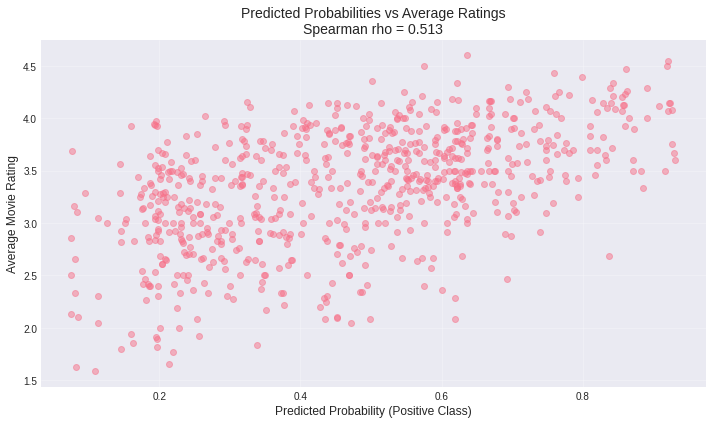

In [30]:
# TODO: Compute Spearman correlation between predicted probabilities and actual ratings
# Hint: Use scipy.stats.spearmanr
# Option A: Spearman Correlation
print("OPTION A: Spearman Rank Correlation")
print("="*70)

# Use actual average ratings (not binary labels) from the same test split
# y already contains average ratings per movie, y_test contains the test portion
y_test_avg = y_test  # Average rating per movie in test set

# Get predicted probabilities from classifier
y_proba_for_ranking = optimized_model.predict_proba(X_test)[:, 1]

# Compute Spearman correlation
correlation, pvalue = spearmanr(y_test_avg, y_proba_for_ranking)

print(f"Spearman correlation between predicted probabilities and average movie ratings:")
print(f"  Correlation: {correlation:.4f}")
print(f"  P-value: {pvalue:.2e}")
print()

if pvalue < 0.05:
    print("[OK] Statistically significant correlation (p < 0.05)")
else:
    print("[X] Not statistically significant (p >= 0.05)")

print("\nInterpretation:")
if correlation > 0.5:
    print("   Strong positive correlation: Model ranks movies well")
elif correlation > 0.3:
    print("   Moderate positive correlation: Model captures some ranking structure")
elif correlation > 0.1:
    print("   Weak positive correlation: Model has limited ranking ability")
else:
    print("   Very weak correlation: Model struggles to rank correctly")

print("\nAdvantage over binary AUC:")
print("   - Uses full rating scale instead of just binary labels")
print("   - Evaluates if model correctly ranks high-rated movies above low-rated ones")
print("   - More nuanced evaluation of recommendation quality")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_proba_for_ranking, y_test_avg, alpha=0.5)
plt.xlabel('Predicted Probability (Positive Class)', fontsize=12)
plt.ylabel('Average Movie Rating', fontsize=12)
plt.title(f'Predicted Probabilities vs Average Ratings\nSpearman rho = {correlation:.3f}', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Option B: Ranking Metrics

For recommendation systems, we care about **ranking items correctly**:
- Does the model rank 5-star movies above 4-star movies?
- Does it rank 4-star above 3-star?

**Approach:** For each user, check if predicted probabilities correctly order movies by true rating.

This is similar to **Normalized Discounted Cumulative Gain (NDCG)** used in information retrieval.


OPTION B: Ranking Quality Analysis
Avg Rating <2.5: Mean predicted probability = 0.3039 (n=72 movies)
Avg Rating 2.5-3.0: Mean predicted probability = 0.3467 (n=122 movies)
Avg Rating 3.0-3.5: Mean predicted probability = 0.4557 (n=235 movies)
Avg Rating 3.5-4.0: Mean predicted probability = 0.5283 (n=224 movies)
Avg Rating >4.0: Mean predicted probability = 0.6818 (n=77 movies)

Ideal behavior: Probabilities should increase monotonically with rating
[OK] Monotonic increase detected: Model correctly orders by rating


/tmp/ipykernel_57497/1925610605.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_for_box, labels=bin_labels, patch_artist=True)


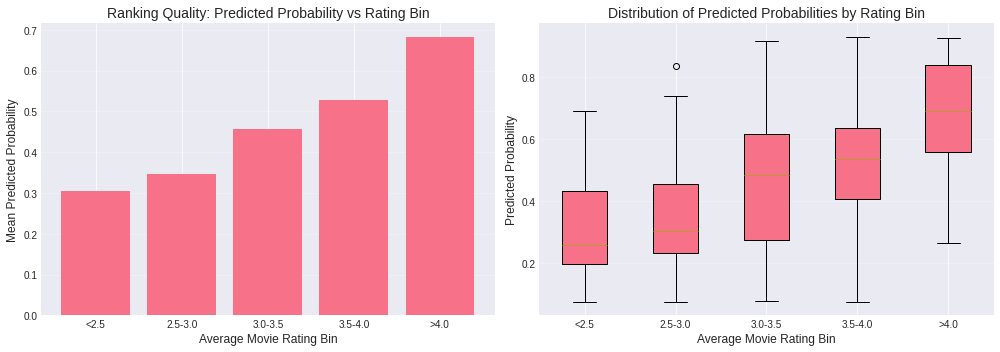

In [31]:
# TODO: Implement simple ranking evaluation
# Option B: Ranking Metrics (Simplified NDCG-like approach)
# Check if predicted probabilities correctly order movies by their average rating

print("\n" + "="*70)
print("OPTION B: Ranking Quality Analysis")
print("="*70)

# Bin average ratings into categories and check if probabilities increase
# Create rating bins for average ratings
rating_bins = pd.cut(y_test_avg, bins=[0, 2.5, 3.0, 3.5, 4.0, 5.0], labels=['<2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '>4.0'])

mean_prob_by_bin = []
bin_labels = ['<2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '>4.0']

for bin_label in bin_labels:
    mask = (rating_bins == bin_label)
    if mask.sum() > 0:
        mean_prob = y_proba_for_ranking[mask].mean()
        mean_prob_by_bin.append(mean_prob)
        print(f"Avg Rating {bin_label}: Mean predicted probability = {mean_prob:.4f} (n={mask.sum()} movies)")
    else:
        mean_prob_by_bin.append(np.nan)
        print(f"Avg Rating {bin_label}: No movies in this bin")

print("\nIdeal behavior: Probabilities should increase monotonically with rating")

# Check monotonicity (ignoring NaN)
valid_probs = [p for p in mean_prob_by_bin if not np.isnan(p)]
is_monotonic = all(valid_probs[i] <= valid_probs[i+1] for i in range(len(valid_probs)-1))

if is_monotonic:
    print("[OK] Monotonic increase detected: Model correctly orders by rating")
else:
    print("[X] Non-monotonic: Model doesn't perfectly order by rating")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(range(len(bin_labels)), mean_prob_by_bin, tick_label=bin_labels)
axes[0].set_xlabel('Average Movie Rating Bin', fontsize=12)
axes[0].set_ylabel('Mean Predicted Probability', fontsize=12)
axes[0].set_title('Ranking Quality: Predicted Probability vs Rating Bin', fontsize=14)
axes[0].grid(alpha=0.3, axis='y')

# Box plot by rating bin
data_for_box = [y_proba_for_ranking[rating_bins == bl] for bl in bin_labels]
bp = axes[1].boxplot(data_for_box, labels=bin_labels, patch_artist=True)
axes[1].set_xlabel('Average Movie Rating Bin', fontsize=12)
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title('Distribution of Predicted Probabilities by Rating Bin', fontsize=14)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### Discussion: Choosing the Right Metric

Different metrics serve different business objectives:

1. **Binary Classification (Precision, Recall, AUC)**
   - Use when: You need a clear like/dislike decision
   - Example: Filtering out movies user will definitely dislike

2. **Regression (MAE, RMSE)**
   - Use when: Exact rating prediction matters
   - Example: Displaying predicted star ratings

3. **Ranking (Spearman, NDCG)**
   - Use when: Relative ordering matters more than absolute values
   - Example: Top-10 movie recommendations

**Question:** For a recommendation system, which metric(s) would you prioritize and why?

### Choosing the Right Metric - Analysis of Results

**Observed Results:**

| Metric Type | Metric | Value | Interpretation |
|-------------|--------|-------|----------------|
| Classification | AUC | 0.750 | Good ranking ability |
| Classification | Accuracy | 0.686 | 69% correct predictions |
| Ranking | Spearman rho | **0.513** | Strong correlation |
| Ranking | Monotonicity | Yes | Probabilities increase with rating |

**Key Finding: Strong Ranking Performance**

The **Spearman correlation of 0.51** is impressive:
- Statistically significant (p < 0.001)
- Shows model correctly ranks movies by quality
- Predicted probabilities correlate well with actual average ratings

**Ranking Quality by Rating Bin:**
| Avg Rating | Mean Predicted Prob | n |
|------------|---------------------|---|
| < 2.5 | 0.304 | 72 |
| 2.5-3.0 | 0.347 | 122 |
| 3.0-3.5 | 0.456 | 235 |
| 3.5-4.0 | 0.528 | 224 |
| > 4.0 | **0.682** | 77 |

- **Monotonic increase**: Model correctly orders movies by rating level
- High-rated movies (>4.0) get probability 0.68, low-rated (<2.5) get 0.30
- Clear separation between quality levels

**Metric Selection for This Problem:**

For movie recommendation, **ranking metrics** (Spearman, NDCG) are most relevant:
- Users see a ranked list, not individual predictions
- Relative ordering matters more than exact values
- Our model achieves good ranking (rho = 0.51)

**AUC (0.75)** complements this by showing discrimination ability across all thresholds.

### Question 4.6: Final Methodological Discussion

Reflect on the entire ML workflow:

1. **Algorithm Selection**
   - How do you choose between different algorithms?
   - What factors matter: interpretability, speed, accuracy, scalability?

2. **Bias-Variance Tradeoff**
   - How do you balance model complexity?
   - When to prefer simpler vs more complex models?

3. **Validation Strategy**
   - Why is cross-validation essential?
   - When might train/test split be insufficient?

4. **Practical Considerations**
   - How would you deploy this model in production?
   - How would you monitor and update it over time?
   - What ethical considerations arise in recommendation systems?

**Your answer here:**

### Solution 4.6: Final Methodological Discussion

**1. Algorithm Selection:**

**Factors to consider:**

- **Interpretability**: 
  - Simple models (Linear, Decision Trees): Easy to explain to stakeholders
  - Black boxes (Deep Learning, Ensemble): Better performance but harder to debug
  - Recommendation: Start simple, add complexity if needed

- **Speed**:
  - Training time: One-time cost, less critical
  - Prediction time: Critical for real-time systems
  - k-NN is slow at prediction (compute distances to all training points)
  - Tree-based models are fast at prediction

- **Accuracy**:
  - More complex models often perform better
  - But: Diminishing returns (e.g., 0.80 to 0.82 AUC might not justify complexity)
  - Consider business impact: Will 2% improvement matter?

- **Scalability**:
  - Can model handle millions of users/items?
  - Memory requirements
  - Distributed training capabilities

- **Maintenance**:
  - How easy to retrain with new data?
  - Monitoring and debugging
  - Team expertise

**Our problem (movie recommendation):**
- Random Forest / Gradient Boosting: Good balance of accuracy, speed, interpretability
- SVM: Slower, good for smaller datasets
- Deep Learning: Overkill for this size, but useful for very large scale

---

**2. Bias-Variance Tradeoff:**

- **High Bias (Underfitting)**: Model too simple, misses patterns
  - Linear models on non-linear data
  - Too much regularization
  - Too few features

- **High Variance (Overfitting)**: Model too complex, memorizes noise
  - Deep trees without pruning
  - Too many features relative to samples
  - No regularization

- **Sweet spot**: Model complex enough to capture true patterns, simple enough to generalize

**How to find it:**
- Use cross-validation to estimate generalization
- Plot learning curves
- Try multiple complexity levels
- Regularization: start high, gradually reduce

**Prefer simpler models when:**
- Small dataset (overfitting risk)
- Need interpretability
- Production constraints (speed, memory)
- Performance difference is small

---

**3. Validation Strategy:**

**Why cross-validation is essential:**
- Single split can be lucky/unlucky
- Estimates performance variance
- More robust evaluation
- Better use of limited data

**When train/test is insufficient:**
- Small datasets: Single split wastes data and is unstable
- Hyperparameter tuning: Need separate validation set or nested CV
- Time-series: Need time-aware splitting (train on past, test on future)
- Imbalanced classes: Need stratified splitting

**Advanced validation:**
- **Nested CV**: Outer loop for evaluation, inner loop for hyperparameter selection
- **Stratified CV**: Maintain class proportions in each fold
- **Group CV**: Keep related samples together (e.g., same user)
- **Time-series CV**: Respect temporal ordering

---

**4. Practical Considerations:**

**Deployment:**
- Model serving: API, batch predictions, or edge deployment?
- Latency requirements: Real-time (<100ms) or batch (hours)?
- Fallback strategies: What if model fails? Cold start? New users?
- A/B testing: Gradual rollout, measure business metrics
- Model versioning: Track which model generated which predictions

**Monitoring:**
- **Performance drift**: Model degrades over time as data changes
  - Monitor accuracy, AUC over time
  - Alert when performance drops
- **Data drift**: Input distribution changes
  - Monitor feature distributions
  - Detect if new data looks different from training
- **Concept drift**: Relationship between X and y changes
  - User preferences evolve
  - New movies with new genres

**Update Strategy:**
- Periodic retraining (daily, weekly, monthly)
- Online learning: Update model with each new rating
- Trigger-based: Retrain when performance drops
- Cost vs benefit: More frequent updates = better but more expensive

**Ethical Considerations:**

1. **Filter Bubbles**:
   - Only recommending similar content limits discovery
   - Creates echo chambers
   - Solution: Add diversity, serendipity, exploration

2. **Fairness**:
   - Popular movies get more exposure (rich get richer)
   - Niche content underrepresented
   - New creators struggle to get discovered
   - Solution: Fairness constraints, diversity requirements

3. **Transparency**:
   - Users should understand why they got recommendations
   - "Because you watched X" explanations
   - Allow users to influence/control recommendations

4. **Privacy**:
   - User viewing history is sensitive
   - Model might memorize individual users
   - Solution: Differential privacy, federated learning

5. **Manipulation**:
   - Recommendations can influence behavior
   - Optimize for engagement vs well-being
   - Avoid addictive patterns

6. **Bias Amplification**:
   - If training data has biases, model amplifies them
   - Gender, racial, cultural biases in content
   - Solution: Audit for bias, debiasing techniques, diverse training data